## The Keras Functional API

In [12]:
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Embedding, Flatten, Subtract, Concatenate
from keras.utils import to_categorical
from keras.optimizers import Adam

from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

import os

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
games_season = pd.read_csv('basketball_data/games_season.csv')
games_season.head()

,season,team_1,team_2,home,score_diff,score_1,score_2,won
0,1985,3745,6664,0,17,81,64,1
1,1985,126,7493,1,7,77,70,1
2,1985,288,3593,1,7,63,56,1
3,1985,1846,9881,1,16,70,54,1
4,1985,2675,10298,1,12,86,74,1


In [3]:
games_tourney = pd.read_csv('basketball_data/games_tourney.csv')
games_tourney.head()

,season,team_1,team_2,home,seed_diff,score_diff,score_1,score_2,won
0,1985,288,73,0,-3,-9,41,50,0
1,1985,5929,73,0,4,6,61,55,1
2,1985,9884,73,0,5,-4,59,63,0
3,1985,73,288,0,3,9,50,41,1
4,1985,3920,410,0,1,-9,54,63,0


In [14]:
input_tensor = Input(shape=(1,))
print(input_tensor)

dense_1/dense_2/input_5


In [7]:
output_layer = Dense(1)
print(output_layer)

In [8]:
output_tensor = output_layer(input_tensor)
print(output_tensor)

AttributeError: ('The following error happened while compiling the node', DotModulo(A, s, m, A2, s2, m2), '\n', "module 'numpy.core.multiarray' has no attribute '_get_ndarray_c_version'")

In [32]:
model = Model(input_tensor, output_tensor)

In [33]:
model.compile(optimizer='adam', loss='mae')

In [34]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


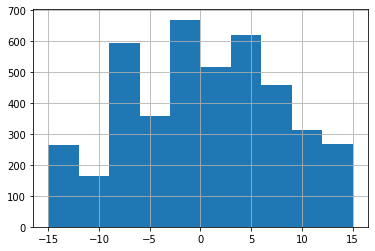

In [35]:
games_tourney['seed_diff'].hist()

In [36]:
games_tourney.shape

(4234, 9)

#### Train on Pre-Season data, Evaluate on Post-Season Data

In [37]:
x_train = games_tourney[games_tourney['season']<2012]['seed_diff']
y_train = games_tourney[games_tourney['season']<2012]['score_diff']
x_test = games_tourney[games_tourney['season']==2012]['seed_diff']
y_test = games_tourney[games_tourney['season']==2012]['score_diff']

In [38]:
len(x_train)

3430

In [39]:
len(x_test)

134

In [40]:
model.fit(x_train, y_train,
          batch_size=64,
          validation_split=0.2,
          verbose=True
         )

Train on 2744 samples, validate on 686 samples
Epoch 1/1
2744/2744 [==============================] - 1s 260us/step - loss: 9.1596 - val_loss: 8.9760


In [43]:
model.evaluate(x_test, y_test)

134/134 [==============================] - 0s 70us/step


8.051775092509255

### Categorical Recap
**(1)** LabelEncoder fit_transform   
**(2)** keras.utils to_categorical

In [45]:
some_list = ['A', 'B', 'A', 'B', 'A', 'B', 'A', 'B']

In [50]:
enc = LabelEncoder()

In [51]:
encoded = enc.fit_transform(some_list)
encoded

array([0, 1, 0, 1, 0, 1, 0, 1])

In [57]:
to_categorical(encoded, num_classes=4) # num_classes is optional

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)

## Two Input Networks Using Categorical Embeddings, Shared Layers, and Merge Layers 

### Categorical Embeddings

In [99]:
input_tensor = Input(shape=(1,))

In [100]:
games_season['team_1'].nunique()

10888

In [101]:
games_season['team_2'].nunique()

10888

In [102]:
n_teams = 10888

embed_layer = Embedding(input_dim=n_teams,
                        input_length=1,
                        output_dim=1,
                        name='Team-Strength-Lookup'
                       )

embed_tensor = embed_layer(input_tensor)

In [103]:
flatten_tensor = Flatten()(embed_tensor)

In [104]:
team_strength_model = Model(input_tensor, flatten_tensor)

In [105]:
team_strength_model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
Team-Strength-Lookup (Embedd (None, 1, 1)              10888     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1)                 0         
Total params: 10,888
Trainable params: 10,888
Non-trainable params: 0
_________________________________________________________________


### Multiple Inputs: Shared Layers and Merge Layers

In [86]:
team_1_in = Input(shape=(1,), name='Team-1-In')
team_2_in = Input(shape=(1,), name='Team-2-In')

In [87]:
team_1_strength = team_strength_model(team_1_in)
team_2_strength = team_strength_model(team_2_in)

In [88]:
score_diff = Subtract()([team_1_strength, team_2_strength])

In [89]:
model = Model([team_1_in, team_2_in], score_diff)

In [90]:
model.compile(optimizer='adam', loss='mean_absolute_error')

In [91]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Team-1-In (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
Team-2-In (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
model_4 (Model)                 (None, 1)            10888       Team-1-In[0][0]                  
                                                                 Team-2-In[0][0]                  
__________________________________________________________________________________________________
subtract_3 (Subtract)           (None, 1)            0           model_4[9][0]              

In [92]:
input_1 = games_season['team_1']
input_2 = games_season['team_2']

In [93]:
model.fit([input_1, input_2],
          games_season['score_diff'],
          batch_size=2048,
          epochs=1,
          validation_split=0.1,
          verbose=True
         )

Train on 280960 samples, validate on 31218 samples
Epoch 1/1
280960/280960 [==============================] - 2s 7us/step - loss: 12.1204 - val_loss: 11.8384


In [95]:
input_1 = games_tourney['team_1']
input_2 = games_tourney['team_2']

In [96]:
model.evaluate([input_1, input_2], games_tourney['score_diff'], verbose=True)

4234/4234 [==============================] - 0s 30us/step


11.680078066797487

## 3 or more Inputs

In [130]:
team_1_in = Input(shape=(1,), name='Team-1-In')
team_2_in = Input(shape=(1,), name='Team-2-In')

home_in = Input(shape=(1,), name='Home-In')

In [131]:
team_1_strength = team_strength_model(team_1_in)
team_2_strength = team_strength_model(team_2_in)

In [132]:
out = Concatenate()([team_1_strength, team_2_strength, home_in])
out = Dense(1)(out)

In [133]:
model = Model([team_1_in, team_2_in, home_in], out)

In [134]:
model.compile(optimizer='adam', loss='mae')

In [135]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Team-1-In (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
Team-2-In (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
model_6 (Model)                 (None, 1)            10888       Team-1-In[0][0]                  
                                                                 Team-2-In[0][0]                  
__________________________________________________________________________________________________
Home-In (InputLayer)            (None, 1)            0                                      

In [136]:
training = model.fit([games_season['team_1'], games_season['team_2'], games_season['home']],
          games_season['score_diff'],
          epochs=1,
          validation_split=0.1,
          verbose=True,
          batch_size=2048
         )

Train on 280960 samples, validate on 31218 samples
Epoch 1/1
280960/280960 [==============================] - 2s 7us/step - loss: 11.9842 - val_loss: 12.4003


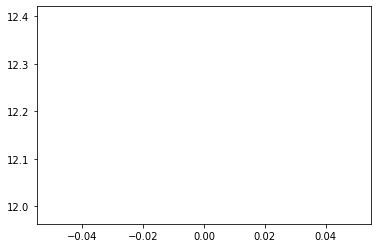

In [137]:
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.show()

In [138]:
model.evaluate([games_tourney['team_1'], games_tourney['team_2'], games_tourney['home']], games_tourney['score_diff'])

4234/4234 [==============================] - 0s 44us/step


11.67970563017314

### Stacking Models
Prediction of a model as Input to another model

In [139]:
games_tourney['pred'] = model.predict([games_tourney['team_1'], games_tourney['team_2'], games_tourney['home']])

In [140]:
input_tensor = Input(shape=(3,))
output_tensor = Dense(1)(input_tensor)

In [141]:
model = Model(input_tensor, output_tensor)

In [142]:
model.compile(optimizer='adam', loss='mae')

In [143]:
games_tourney_train = games_tourney[games_tourney['season']<2010]
games_tourney_test = games_tourney[games_tourney['season']>=2010]

In [145]:
model.fit(games_tourney_train[['home', 'seed_diff', 'pred']],
          games_tourney_train['score_diff'],
          epochs=1,
          verbose=True
         )

Epoch 1/1
3168/3168 [==============================] - 0s 62us/step - loss: 16.1336


In [146]:
model.evaluate(games_tourney_test[['home', 'seed_diff', 'pred']],
               games_tourney_test['score_diff']
              )

1066/1066 [==============================] - 0s 185us/step


14.887252362092038

## Multiple Outputs

In [178]:
input_tensor = Input(shape=(2,))
output_tensor = Dense(2)(input_tensor)

In [179]:
model = Model(input_tensor, output_tensor)

In [180]:
model.compile(optimizer='adam', loss='mae')

In [181]:
model.fit(games_tourney_train[['seed_diff', 'pred']],
          games_tourney_train[['score_1', 'score_2']],
          epochs=500,
          batch_size=32,
          verbose=False
         )

In [182]:
model.get_weights()

[array([[  0.60860145,  -0.4463818 ],
        [-46.905964  , -48.350075  ]], dtype=float32),
 array([49.423653, 49.425747], dtype=float32)]

In [183]:
model.evaluate(games_tourney_test[['seed_diff', 'pred']],
          games_tourney_test[['score_1', 'score_2']])

1066/1066 [==============================] - 0s 257us/step


20.785604691639627

In [184]:
games_tourney_train.mean()

season        1997.045455
team_1        5546.025568
team_2        5546.025568
home             0.000000
seed_diff        0.000000
score_diff       0.000000
score_1         71.912247
score_2         71.912247
won              0.500000
pred            -0.036293
dtype: float64

### Single Model for Regression and Classification

In [196]:
input_tensor = Input(shape=(2,))
output_tensor_reg = Dense(1, activation='linear', use_bias=False)(input_tensor)
output_tensor_class = Dense(1, activation='sigmoid', use_bias=False)(output_tensor_reg)

In [197]:
model = Model(input_tensor, [output_tensor_reg, output_tensor_class])

In [198]:
model.compile(optimizer=Adam(0.01), loss=['mean_absolute_error', 'binary_crossentropy'])

In [199]:
model.fit(games_tourney_train[['seed_diff', 'pred']],
          [games_tourney_train[['score_diff']], games_tourney_train[['won']]],
          epochs=100,
          verbose=False
         )

In [201]:
model.evaluate(games_tourney_test[['seed_diff', 'pred']],
          [games_tourney_test[['score_diff']], games_tourney_test[['won']]])

1066/1066 [==============================] - 0s 403us/step


[9.703014928449162, 9.11923925245904, 0.5837756601104593]

In [202]:
# [Sum of losses, Reg Loss, Class Loss]

In [206]:
print(model.get_weights())

[array([[1.189365],
       [9.746947]], dtype=float32), array([[0.13507919]], dtype=float32)]


In [207]:
games_tourney_train.mean()

season        1997.045455
team_1        5546.025568
team_2        5546.025568
home             0.000000
seed_diff        0.000000
score_diff       0.000000
score_1         71.912247
score_2         71.912247
won              0.500000
pred            -0.036293
dtype: float64